# Evaluation Notebook

Purpose of this notebook is to compute relevant eval statistics.

Here are the main evaluation interests of Radix and the metrics I think capture them well:

* Bias - When predictions are aggregated, do they add up to the correct number of renewals? Basically a measure of calibration.
    * MAPE (Mean Absolute Percentage Error) of the sum of predicted renewals per tld-renewal should handle this well.
* Confusion Matrix
    * TP, TN, FP, FN with 0.5 threshold?
    * AUC? (redundant with Gini below)
* Lift
    * Gini Coefficient/area under gains curve
    * Lift at 10%?

In [1]:
library(tidyverse)
library(yardstick)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

For binary classification, the first factor level is assumed to be the event.
Use the argument `event_level = "second"` to alter this as needed.


Attaching package: ‘yardstick’


The following object is masked from ‘package:readr’:

    spec




In [2]:
# # Old performance reporting
# options(warn=-1)
# predDir <- '/home/jupyter/Domains_202003/data/output/dp_predictions/'
# rf_preds <- readRDS(paste0(predDir, 'baseline_predictions.RDS'))
# rf_seg_preds <- readRDS(paste0(predDir, 'ranger_seg.RDS'))
# rf_seg2_preds <- readRDS(paste0(predDir, 'ranger_seg2.RDS'))
# group_preds <- readRDS(paste0(predDir, 'baseline_grouping_predictions.RDS'))

In [17]:
load("/home/jupyter/Domains_202003/data/output/dp_models_20201104_/preds_test/preds_agg_glm_ALL.RData")

ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [18]:
options(warn=-1)
df <- read.csv('/home/jupyter/Domains_202003/data/output/dp_models_20201104_all/preds/preds_test_with_meta.csv')
print(dim(df))
head(df)

[1] 919586     64


,domain,domain_id,renewed_count,renewal_type,expiry_date,creation_date,creation_time,tld,registrar,reseller,⋯,pred_seg2_glm_ALL,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_rf_ALL,l10_best_model,pred_meta_l10,auc_best_model,pred_meta_auc,mape_best_model,pred_meta_mape
,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>
1,immeo.tech,137308830,1,FirstTime,2020-10-25,2019-10-25,2019-10-25 02:23:49,tech,CSL,CSL,⋯,0.007,0.003,0.1952172,0.22720395,pred_agg_glm_ALL,0.320,pred_seg_glm_ALL,0.003,pred_seg_rf_ALL,0.1952172
2,unitedlinesgroup.tech,137712590,1,FirstTime,2020-10-27,2019-10-27,2019-10-27 13:19:15,tech,CSL,CSL,⋯,0.001,0.003,0.3091089,0.31140437,pred_agg_glm_ALL,0.371,pred_seg_glm_ALL,0.003,pred_seg_rf_ALL,0.3091089
3,torsbo.tech,137863570,1,FirstTime,2020-10-28,2019-10-28,2019-10-28 22:31:39,tech,CSL,CSL,⋯,0.000,0.000,0.1571547,0.31257162,pred_agg_glm_ALL,0.344,pred_seg_glm_ALL,0.000,pred_seg_rf_ALL,0.1571547
4,bestform.tech,138683110,1,FirstTime,2020-10-31,2019-10-31,2019-10-31 09:32:31,tech,CSL,CSL,⋯,0.000,0.000,0.1479771,0.09338231,pred_agg_glm_ALL,0.223,pred_seg_glm_ALL,0.000,pred_seg_rf_ALL,0.1479771
5,marouf.tech,139110540,1,FirstTime,2020-11-02,2019-11-02,2019-11-02 11:28:55,tech,CSL,CSL,⋯,0.001,0.305,0.1632089,0.18113906,pred_agg_glm_ALL,0.496,pred_seg_glm_ALL,0.305,pred_seg_rf_ALL,0.1632089
6,fundland.tech,139203275,1,FirstTime,2020-11-03,2019-11-03,2019-11-03 07:37:23,tech,CSL,CSL,⋯,0.001,0.060,0.1635743,0.08184104,pred_agg_glm_ALL,0.287,pred_seg_glm_ALL,0.060,pred_seg_rf_ALL,0.1635743


In [19]:
table(df$tld, df$registrar)

         
          1&1 Internet Alibaba Alibaba SG Ascio Automattic Beget Bizcn
  fun               18   25258        212     2          7   705     7
  host               1       0          0     0          6   199     2
  online          3479    5369        372   456        182  5065    22
  press              0    4901        523     0         60     8     0
  site             291   39199        872   127         21  4364    88
  space             61    1261        494     0         22   924     1
  store            550   24084        194   340         19    52    44
  tech             159    1915        871   210         32    20     8
  website           72    1218        473     4          8   334     0
         
          CHENGDU WEST Crazy Domains Cronon AG   CSL Domain.com - Registrar
  fun             5221             3         9    26                     22
  host            1186             0         0     0                     37
  online          4169         15574      

In [20]:
pred_cols <- names(df)[grepl( "^pred_" , names(df))]
pred_cols

[1] "pred_agg_rf_ALL"   "pred_agg_glm_ALL"  "pred_seg2_glm_ALL"
[4] "pred_seg_glm_ALL"  "pred_seg_rf_ALL"   "pred_seg2_rf_ALL" 
[7] "pred_meta_l10"     "pred_meta_auc"     "pred_meta_mape"

In [24]:
# df[,"target"] <- as.integer(df$renewal_status == "Renewed")
df[,"target"] <- as.integer(df$renewal_status)

In [60]:
# Helper metrics
l10_vec <- function(pred_vec, target_vec, p=0.10) {
    # Convert from factor to binary
    target_vec <- as.integer(target_vec)
    
    # Drop missing
    non_missing <- !is.na(pred_vec)
    pred_vec <- pred_vec[non_missing]
    target_vec <- target_vec[non_missing]
    
    # Get prevalence
    prop <- mean(target_vec)
    
    # Calculate number returned at specified proportion
    n_rows <- max(round(p * length(pred_vec)), 1)
    argsort <- order(desc(pred_vec))
    l10_prop <- mean(target_vec[argsort][1:n_rows])
    
    # Return lift at 10%
    return(ifelse(prop == 0, 0, l10_prop / prop))
}

In [63]:
augc_vec <- function (pred_vec, target_vec) {
    # Convert from factor to binary
    target_vec <- as.integer(target_vec)
    
    # Drop missing
    non_missing <- !is.na(pred_vec)
    pred_vec <- pred_vec[non_missing]
    target_vec <- target_vec[non_missing]    
    
    actu_renwd <- sum(target_vec)
    if (actu_renwd > 0) {
        argsort <- order(desc(pred_vec))
        cs <- cumsum(target_vec[argsort])
        gain <- cs / actu_renwd
        auc <- sum(gain) / length(pred_vec)
    } else {
        auc = 0
    }
    auc
}

In [64]:
tmp = df[df$tld_registrar_index == "fun1&1 internet",]
augc_vec(tmp$pred_agg_glm_ALL, tmp$target)

[1] 0.654321

In [65]:
eval_preds <- function(test, col) {
    test$target = as.factor(test$target)
    test %>% group_by(tld_registrar_index) %>%
        summarise(roc_auc = roc_auc_vec(get(col), truth=target, event_level = "second"),
                  log_loss = mn_log_loss_vec(get(col), truth=target, event_level = "second"),
                  mape = mape_vec(sum(as.numeric(target) - 1), sum(get(col))),
                  l10 = l10_vec(pred_vec=get(col), target_vec=target),
                  augc = augc_vec(pred_vec=get(col), target_vec=target),
                  average_precision = average_precision_vec(get(col), truth=target, event_level = "second"),
                  specificity = specificity_vec(factor(round(get(col)), levels=c(0,1)), truth=target, event_level = "second"),
                  sensitivity = sensitivity_vec(factor(round(get(col)), levels=c(0,1)), truth=target, event_level = "second"),
                  precision = precision_vec(factor(round(get(col)), levels=c(0,1)), truth=target, event_level = "second"),
                  prev = mean(as.numeric(target)) - 1,
                  mean_pred = mean(get(col)),
                  total_actual = sum(as.numeric(target) - 1),
                  total_pred = sum(get(col)),
                  n=n()) %>% arrange(desc(n))# %>% filter((registrar == "Go Daddy") | (registrar == "Namecheap"))
}
all_eval <- list()
for (col in pred_cols) {
    all_eval[[col]] <- eval_preds(df, col)
}

In [66]:
all_eval[['pred_agg_glm_ALL']]

tld_registrar_index,roc_auc,log_loss,mape,l10,augc,average_precision,specificity,sensitivity,precision,prev,mean_pred,total_actual,total_pred,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
sitegmo,0.9006804,0.072819485,9.661362,1.1069638,0.5062704,0.342715417,0.9979166,0.1660290742,0.56510417,0.016043897,0.014493838,1307,1180.726,81464
sitenamecheap,0.6257433,0.110246162,75.185958,1.0438106,0.5024266,0.058229877,0.9999861,0.0000000000,0.00000000,0.020030585,0.035090773,1467,2569.978,73238
sitealibaba,0.9221046,0.043651354,6.464815,1.0616332,0.5034492,0.160257135,0.9999743,0.0123456790,0.80000000,0.008265517,0.007731167,324,303.054,39199
sitego daddy,0.8185395,0.177800609,6.959034,1.1447780,0.5158289,0.187888215,0.9995664,0.0017045455,0.18750000,0.055448789,0.059307489,1760,1882.479,31741
sitereg.ru,0.6880103,0.106139779,50.184987,1.0580836,0.5042287,0.090217992,1.0000000,0.0000000000,NA,0.023540549,0.035354370,746,1120.380,31690
sitepdr china,0.7582697,0.016905140,13.245570,1.0113105,0.5007494,0.008774414,1.0000000,0.0000000000,NA,0.002627203,0.002279215,79,68.536,30070
onlinego daddy,0.7223878,0.397823837,10.483356,1.1739428,0.5255580,0.309191283,0.9886725,0.0492424242,0.44918699,0.157961425,0.174521083,4488,4958.493,28412
onlinenamecheap,0.6501243,0.257818177,72.023611,1.1129087,0.5090441,0.155627561,0.9979426,0.0200000000,0.41860465,0.068960233,0.118627883,1800,3096.425,26102
funalibaba,0.9142462,0.065003143,10.477340,1.0831437,0.5064832,0.186664957,1.0000000,0.0073891626,1.00000000,0.016074115,0.014389975,406,363.462,25258


In [9]:
comp_perf <- function(eval_df_list, metrics = c(), gen_cols = c()) {
    keep_cols <- c('tld', 'registrar', metrics)
#     eval1 <- eval1 %>% select(all_of(c(keep_cols, 'n')))
#     print(head(eval1))
    eval_results <- list()
    last_col = names(eval_df_list)[length(eval_df_list)]
    for (col in names(eval_df_list)) {
        rep_cols <- paste(metrics, col, sep="_")
        df <- eval_df_list[[col]]
        if (col == last_col) {
            df <- df[, c(keep_cols, gen_cols)]
        } else{
            df <- df[, keep_cols]
        }
        df <- df %>% rename_at(vars(metrics), ~rep_cols)
        eval_results[[col]] <- df
    }

#     evals <- eval1 %>% inner_join(eval2, by=c("tld", "registrar"), suffix=suff)
    evals <- Reduce(function(...) merge(..., by=c("tld", "registrar"), all=T), eval_results)
    evals
}

# eval_df_list = list(rf_eval, rf_seg_eval, rf_seg2_eval, group_eval)                    
evals <- comp_perf(all_eval, metrics=c("mape"), gen_cols=c("n", "prev"))
evals %>% arrange(desc(n)) %>% na.exclude

ERROR: Error: Can't subset columns that don't exist.
[31m✖[39m Columns `tld` and `registrar` don't exist.


## Best model chosen by Meta Models

In [27]:
best_model_cols <- names(df)[grepl('best_model', names(df))]

df %>% group_by(tld_registrar_index) %>%
    select(all_of(best_model_cols)) %>%
    summarise_all(first) %>%
    pivot_longer(!tld_registrar_index, names_to="metric", values_to="model") %>%
    select(metric, model) %>%
    mutate(ones = 1) %>%
    pivot_wider(names_from=model, values_from=ones, values_fill=0, values_fn=sum)

Adding missing grouping variables: `tld_registrar_index`



metric,pred_agg_glm_ALL,pred_seg_rf_ALL,pred_seg_glm_ALL,pred_seg2_glm_ALL,pred_agg_rf_ALL,pred_seg2_rf_ALL,NA
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
l10_best_model,127,84,131,181,76,60,11
auc_best_model,134,101,127,120,122,55,11
mape_best_model,129,71,136,142,115,66,11


## Best Performing models on Test Set

In [67]:
# Combine into one df
df_list <- list()
for (model in names(all_eval)) {
    tmp <- all_eval[[model]]
    tmp[,'model'] <- model
    df_list[[model]] <- tmp
}
results <- bind_rows(df_list)
head(results)

tld_registrar_index,roc_auc,log_loss,mape,l10,augc,average_precision,specificity,sensitivity,precision,prev,mean_pred,total_actual,total_pred,n,model
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
sitegmo,0.9736152,0.05115357,89.16774,1.133061,0.5073648,0.43520608,0.9974300,0.235654170,0.5992218,0.016043897,0.03034988,1307,2472.4224,81464,pred_agg_rf_ALL
sitenamecheap,0.7450947,0.10959148,217.80284,1.068574,0.5047234,0.17492730,0.9999443,0.004771643,0.6363636,0.020030585,0.06365777,1467,4662.1676,73238,pred_agg_rf_ALL
sitealibaba,0.9352985,0.04743158,258.25177,1.061886,0.5035517,0.15563072,0.9998199,0.021604938,0.5000000,0.008265517,0.02961136,324,1160.7357,39199,pred_agg_rf_ALL
sitego daddy,0.7324261,0.21060918,80.24787,1.079106,0.5115494,0.13827348,0.9994997,0.011931818,0.5833333,0.055448789,0.09994526,1760,3172.3625,31741,pred_agg_rf_ALL
sitereg.ru,0.6989629,0.11475091,112.77196,1.050993,0.5044840,0.07479221,0.9999031,0.000000000,0.0000000,0.023540549,0.05008769,746,1587.2788,31690,pred_agg_rf_ALL
sitepdr china,0.6995044,0.03051156,711.67816,1.011310,0.5005380,0.01859156,1.0000000,0.000000000,NA,0.002627203,0.02132443,79,641.2257,30070,pred_agg_rf_ALL


In [71]:
metrics <- c('roc_auc', 'log_loss', 'mape', 'l10', 'augc')
results %>% select(all_of(c('tld_registrar_index', 'model', metrics))) %>%
    group_by(tld_registrar_index) %>%
    mutate(
        ll_rank = rank(desc(log_loss)),
        auc_rank = rank(desc(roc_auc)),
        mape_rank = rank(mape),
        l10_rank = rank(desc(l10)),
        augc_rank = rank(desc(augc))
    ) %>%
    ungroup() %>%
    group_by(model) %>%
    select(l10_rank, ll_rank, auc_rank, augc_rank, mape_rank) %>%
    summarise_all(mean)

Adding missing grouping variables: `model`



model,l10_rank,ll_rank,auc_rank,augc_rank,mape_rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pred_agg_glm_ALL,4.940299,5.311940,4.578358,5.036567,4.882090
pred_agg_rf_ALL,4.653731,5.775373,3.997761,4.601493,4.814179
pred_meta_auc,4.780597,5.611194,5.003731,4.600746,5.136567
pred_meta_l10,4.772388,5.026119,5.179851,4.920896,5.183582
pred_meta_mape,5.076866,5.488806,5.477612,4.894776,4.382090
pred_seg_glm_ALL,4.747761,5.102239,4.600000,4.714925,4.680597
pred_seg_rf_ALL,4.976866,5.332090,4.899254,4.869403,4.908955
pred_seg2_glm_ALL,5.493284,2.813433,5.288060,5.550746,5.433582
pred_seg2_rf_ALL,5.558209,4.538806,5.975373,5.810448,5.578358


In [72]:
new_mean <- function(vec, na.rm=F) {
    if (na.rm) {
        vec = vec[(!is.na(vec)) & (!is.infinite(vec))]
    }
    mean(vec)
}


results %>% select(all_of(c('tld_registrar_index', 'model', metrics))) %>%
#     group_by(tld_registrar_index) %>%
#     mutate(auc_rank = rank(desc(roc_auc), ties.method=), mape_rank = rank(mape)) %>%
#     ungroup() %>%
    group_by(model) %>%
    select(roc_auc, mape, l10, augc, log_loss) %>%
    summarise_all(new_mean, na.rm=T)

Adding missing grouping variables: `model`



model,roc_auc,mape,l10,augc,log_loss
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pred_agg_glm_ALL,0.6336300,94.56334,1.077632,0.5642464,0.5103772
pred_agg_rf_ALL,0.6485482,122.07627,1.090383,0.5655534,0.4522401
pred_meta_auc,0.6462018,107.33034,1.085281,0.5413842,1.5130798
pred_meta_l10,0.6283236,98.66943,1.085421,0.5399839,2.1262997
pred_meta_mape,0.6405128,53.28077,1.079971,0.5443152,1.2472890
pred_seg_glm_ALL,0.6318735,59.29935,1.080967,0.5631592,1.5648633
pred_seg_rf_ALL,0.6341160,124.61916,1.076303,0.5638892,0.4698480
pred_seg2_glm_ALL,0.5925520,223.28578,1.052348,0.5396937,4.3997144
pred_seg2_rf_ALL,0.5968603,169.71552,1.061403,0.5405241,1.1684953


In [132]:
metric_rank

[1] "roc_auc_rank" "mape_rank"

## Plot ROC Curves

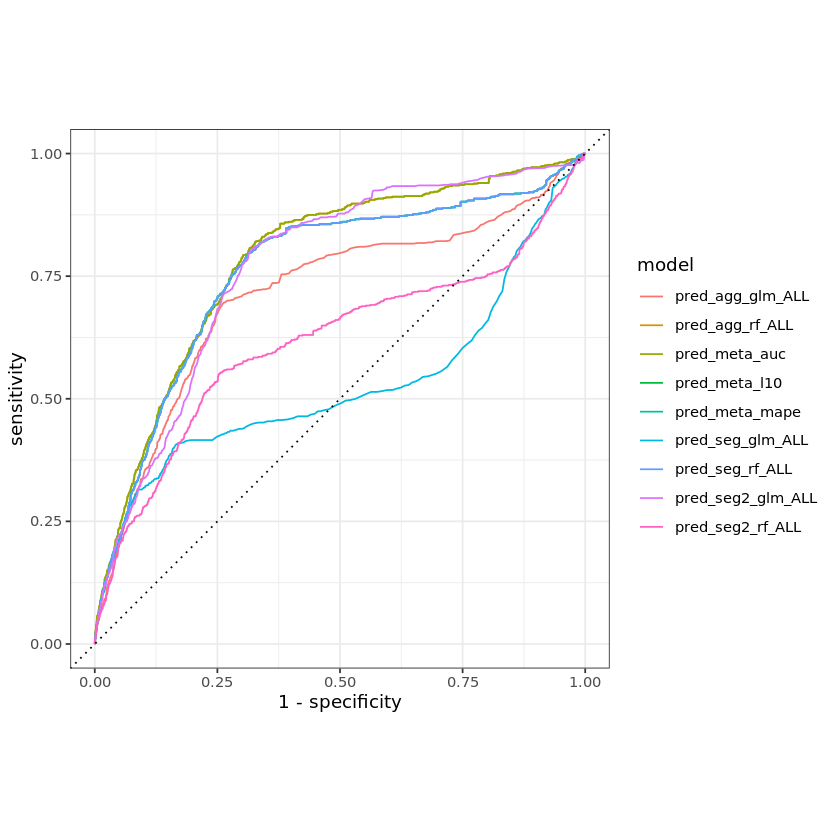

In [75]:
tld_registrar = 'onlinego daddy'
tld_registrar = 'technamecheap'

pred_col = 'pred_seg2_glm_ALL'
df$target <- as.factor(df$target)
df %>% filter(tld_registrar_index == tld_registrar) %>%
    select(all_of(c(pred_cols, 'target'))) %>%
    pivot_longer(!target, names_to='model', values_to='prediction') %>%
    group_by(model) %>%
    roc_curve(truth=target, event_level = "second", prediction) %>%
    autoplot()

In [76]:
colMeans(is.na(df[,pred_cols]))

pred_agg_rf_ALL  pred_agg_glm_ALL pred_seg2_glm_ALL  pred_seg_glm_ALL 
     0.0000000000      0.0000000000      0.0019889385      0.0000000000 
  pred_seg_rf_ALL  pred_seg2_rf_ALL     pred_meta_l10     pred_meta_auc 
     0.0000000000      0.0019889385      0.0006133195      0.0006133195 
   pred_meta_mape 
     0.0006111446

In [113]:
sort(table(df$tld_registrar_index), decreasing=T)


   sitenamecheap     sitego daddy   onlinego daddy  onlinenamecheap 
           73238            31741            28412            26102 
websitenamecheap    spacego daddy    hostnamecheap   spacenamecheap 
           15584            11399            10314            10101 
   storego daddy   storenamecheap    technamecheap     funnamecheap 
            8482             8449             7309             5068 
 websitego daddy     techgo daddy   pressnamecheap      fungo daddy 
            4123             2441             2345             1419 
    hostgo daddy    pressgo daddy 
             373              107 

## Old Predictions

In [5]:
pred_path <- '/home/jupyter/Domains_202003/data/output/dp_models_20201104/preds/preds.csv'
preds <- read.csv(pred_path)
print(dim(preds))
head(preds)

ERROR: Error in file(file, "rt"): cannot open the connection
